# Reaction network and predictability modelling

In [1]:
import csv
import random
import networkx as nx
from os import path
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
from IPython.display import display

from sklearn.manifold import TSNE
import seaborn as sns

sns.set(context="poster", style="ticks", font="Arial", font_scale=1.8,
        rc={"svg.fonttype": "none", "lines.linewidth": 1.5, "figure.autolayout": True,
            "mathtext.fontset": "custom", "mathtext.it": "Arial:italic", "mathtext.rm": "Arial",
            "mathtext.bf": "Arial:bold"})

## Forward and reverse reactions

In [2]:
reaction_dict = {
    "secondary imine formation": "[C,#1:5][C:1](=O)[C,#1:6].[CX4:4][Nh+0:2][CX4:3]>>[*:5][C:1](=[*+:2]([*:4])[*:3])[*:6].O",
    "primary imine formation": "[C,#1:4][C:1](=O)[C,#1:5].[CX4:3][Nh2+0:2]>>[*:4][C:1](=[*+:2][*:3])[*:5].O",
    "primary amine oxidation": "[Nh2+0:1][Ch:2]>>[N:1]=[*:2]",
    "secondary amine oxidation": "[Ch:2][Nh+0:1][C^3:3]>>[*:2]=[N:1][*:3]",
    # "imine-isocyanide attack": "[N:1]=[C^2:2].[C-:3]>>[Nh:1][C:2][C+0:3]",
    "primary imine-amine attack": "[N:1]=[C^2:2].[Nh2X3:3][Ch:4]>>[Nh:1][C:2][*:3][*:4]",
    "secondary imine-amine attack": "[N:1]=[C^2:2].[NhX3:3]([Ch:4])[Ch:5]>>[Nh:1][C:2][*:3]([*:4])[*:5]",
    "amine elimination 1": "[Nh2:1][C:2][ND1X3+0,ND2X3+0:3]>>[C:2]=[*:3].[*:1]",
    "amine elimination 2": "[Nh2:1][C:2][ND3X3+0:3]>>[C:2]=[N+:3].[*:1]",
    "imine reduction": "[N,N+1:1]=[C^2:2]>>[N+0:1][C:2]",
    # "amide hydrolysis": "O=[C:1]-[NX3+0:2].[Oh2:3]>>O=[C:1][*:3].[N:2]",
    # "amide formation": "O=[C:1]-[O:2].[NhX3+0:3]>>O=[C:1][*:3].[O:2]",
    "imine hydrolysis": "[C^2:1]=[NX2+0:2].[Oh2:3]>>[*:1]=[*:3].[N:2]",
    "isocyanate to urea": "O=[C:1]=[N:2].[Nh2:3]>>O=[C:1]([NH:2])[Nh:3]",
    "isocyanide alpha attack": "[C:1]=[N:2].[Ch:3][N+:4]#[C-:5]>>[C:1]([N:2])[*:3][N+:4]#[C-:5]",
    "carbanion attack": "[C:1]=[N:2].[C-:3]>>[C+0:3][C:1][N:2]",
    "isocyanide oxidation": "[N+:1]#[C-:2].[CH3]S([CH3])=[O:3]>>[N+0:1]=[C+0:2]=[O:3]",
    "isocyanate hydrolysis": "O=C=[N:1].[OH2]>>[N:1].O=C=O",
    "nitrilium hydrolysis": "[C+0:1]#[N+:2].[Oh2]>>[C:1](=O)O.[N+0:2]",
    "Ugi reaction": "[Nh:1][CX4:2][C:3]#[N+:4].O=[C:5][Oh:6]>>O=[C:5][*:1][*:2][C:3](=[*:6])[N+0:4]",
    "imine tautomerism": "[Ch^3:1]-[NX2+0:2]=[C^2:3]>>[*:1]=[*:2]-[*:3]",
    "decarboxylation": "[C:1](C(=O)[Oh])[C:2](=[O:3])>>[C:1][C:2](=[O:3]).O=C=O",
    "Ts elimination": "O=[S:3](=O)[CX4:1][ChX4:2]>>[C:1]=[C:2]",  # maybe add alfa-carbonyl on eliminating carbon?
    "Ts reduction": "O=[S:3](=O)[CX4:1]([C^2,C^1,N^1:2])[C^2,C^1,N^1:4]>>[C:1]([C^2,C^1,N^1:2])[C^2,C^1,N^1:4]",
}

reverse_dict = {
    "secondary imine formation": "[C,#1:5][C:1](=[N+:2]([CX4:4])[CX4:3])[C,#1:6].O>>[C,#1:5][C:1](=O)[C,#1:6].[CX4:4][Nh+0:2][CX4:3]",
    "primary imine formation": "[C,#1:4][C:1](=[Nh:2][CX4:3])[C,#1:5].O>>[C,#1:4][C:1](=O)[C,#1:5].[CX4:3][Nh2+0:2]",
    "primary amine oxidation": "[NH:1]=[Ch:2]>>[Nh2+0:1][Ch:2]",
    "secondary amine oxidation": "[Ch:2]=[N:1][C^3:3]>>[Ch:2][Nh+0:1][C^3:3]",
    "imine reduction": "[NhX3:1][Ch:2]>>[*:1]=[C^2:2]",
    "tertiary imine reduction": "[ND3X3+0:1][Ch:2]>>[N+:1]=[C^2:2]",
    # "imine-isocyanide attack": "[Nh:1][C:2][C+0:3]#[N+:5]>>[N:1]=[C^2:2].[C-:3]#[N+:5]",
    "primary imine-amine attack": "[Nh:1][Ch:2][Nh:3][Ch:4]>>[N:1]=[C^2:2].[Nh2X3:3][Ch:4]",
    "secondary imine-amine attack": "[Nh:1][Ch:2][N:3]([Ch:4])[Ch:5]>>[N:1]=[C^2:2].[NhX3:3]([Ch:4])[Ch:5]",
    "amine elimination": "[C:2]=[N,N+:3].[Nh+0:1]>>[*:1][C:2][N+0:3]",
    # "amide formation": "O=[C:1]-[NX3+0:2].[Oh2:3]>>O=[C:1][*:3].[N:2]",
    # "amide hydrolysis": "O=[C:1]-[O:2].[NhX3+0:3]>>O=[C:1][*:3].[O:2]",
    "imine hydrolysis": "[C:1]=[O:3].[CX4,#1][Nh+0:2][CX4,#1]>>[*:1]=[*:2].[*:3]",
    "isocyanate to urea": "O=[C:1]([NH:2])[Nh:3]>>O=[C:1]=[N:2].[Nh2:3]",
    "isocyanide alpha attack": "O=[C:1]([Nh+0:2])[Ch:3][N+:4]#[C-:5]>>O=[*:1]=[*:2].[*:3][*:4]#[*:5]",
    "carbanion attack": "[N+:5]#[C+0:3][C:1][NX3h+0:2]>>[C:1]=[*:2].[C-:3]#[N+:5]",
    "carbanion attack 2": "[N+:5]#[C+0:3][C:1][NX3h0+0:2]>>[C:1]=[*+:2].[C-:3]#[N+:5]",
    "isocyanide oxidation": "[N+0:1]=[C+0:2]=[O:3]>>[N+:1]#[C-:2].[CH3]S([CH3])=[O:3]",
    "isocyanate hydrolysis": "[Nh2+0:1].O=C=O>>O=C=[*:1].[OH2]",
    "nitrilium hydrolysis": "[C:1](=O)[Oh].[Nh2+0:2]-[Ch]>>[C+0:1]#[N+:2].[OH2]",
    "Ugi reaction": "O=[C:1]([NhX3+0:2])[CX4:3][NX3+0:4][C:5]=OC>>[*+:2]#[*:1][*:3][*:4].O=[C:5][OH]",
    "imine tautomerism": "[C^2:1]=[N:2]-[Ch^3:3]>>[*:1]-[N:2]=[*:3]",
    "decarboxylation": "[Ch2:1][C:2](=[O:3])>>[C:1](C(=O)[OH])[C:2](=[O:3])",
    "Ts elimination": "O=[S-:3]=O.[C:1]=[C:2]>>O=[S:3](=O)[*:1][*:2]",
    "Ts reduction": "O=[S-:3]=O.[Ch2X4+0:1]([C^2,C^1,N^1:2])[C^2,C^1,N^1:4]>>O=[S+0:3](=O)[*:1]([*:2])[*:4]",
}

In [24]:
def intramolecular(reaction: AllChem.ChemicalReaction):
    try:
        r1, r2 = reaction.GetReactants()
        _, product_smarts = AllChem.ReactionToSmarts(reaction).split(">>")
    except ValueError:
        return None
    new_smarts = f"({Chem.MolToSmarts(r1)}.{Chem.MolToSmarts(r2)})>>{product_smarts}"
    return AllChem.ReactionFromSmarts(new_smarts)


def products(reaction: AllChem.ChemicalReaction, mols, wt_limit=500):
    products = reaction.RunReactants(mols)
    return {Chem.MolToSmiles(p): p for product in products for p in product}

def products_from_smiles(reaction, smiles, **kwargs):
    return products(reaction, [Chem.MolFromSmiles(s) for s in smiles], **kwargs)

def make_reactions(rxn_dict):
    reactions = {
        name: AllChem.ReactionFromSmarts(reaction_smarts)
        for name, reaction_smarts in rxn_dict.items()
    }

    intramolecular_reactions = {
        f"intramolecular {name}": intramolecular(reaction)
        for name, reaction in reactions.items()
    }
    intramolecular_reactions = {
        name: rxn for name, rxn in intramolecular_reactions.items() if rxn
    }

    reactions.update(intramolecular_reactions)

    return reactions


reactions = make_reactions(reaction_dict)
rev_reactions = make_reactions(reverse_dict)

## Starting materials and products

In [4]:
# starting materials for forward propagation
reagents = ["O=S(=O)(c1ccc(cc1)C)C[N+]#[C-]", "CS(C)=O", "O"]

# products for backward propagation
reagents_rev = ["Cc1ccc(S(=O)(=O)CNC(=O)CN(CC(=O)NCS(=O)(=O)c2ccc(C)cc2)CC(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1", "CSC", "O", "N", "O=C=O", "Cc1ccc([S-](=O)=O)cc1"]

A quick test of the reaction rules

In [26]:
[
    products_from_smiles(reactions["primary imine-amine attack"], ['Cc1ccc(S(=O)(=O)C=N)cc1', 'Cc1ccc(S(=O)(=O)CN)cc1']),
    products_from_smiles(reactions["Ugi reaction"], ["CNC(C)C#[N+]C", "CCC(=O)[O-]"]),
    products_from_smiles(reactions["amine elimination 1"], ['Cc1ccc(S(=O)(=O)CNC(N)S(=O)(=O)c2ccc(C)cc2)cc1']),
    products_from_smiles(reactions["secondary amine oxidation"], ['Cc1ccc(S(=O)(=O)CNCS(=O)(=O)c2ccc(C)cc2)cc1']),
    products_from_smiles(reactions['isocyanide oxidation'], ["[C-]#[N+]CC(=O)NCS(=O)(=O)c1ccc(C)cc1", reagents[1]]),
]

[{'Cc1ccc(S(=O)(=O)CNC(N)S(=O)(=O)c2ccc(C)cc2)cc1': <rdkit.Chem.rdchem.Mol at 0x7f4d78ba3510>},
 {},
 {'Cc1ccc(S(=O)(=O)C=NCS(=O)(=O)c2ccc(C)cc2)cc1': <rdkit.Chem.rdchem.Mol at 0x7f4d78ba3970>,
  'N': <rdkit.Chem.rdchem.Mol at 0x7f4d78ba34a0>},
 {'Cc1ccc(S(=O)(=O)C=NCS(=O)(=O)c2ccc(C)cc2)cc1': <rdkit.Chem.rdchem.Mol at 0x7f4d78ba3a50>},
 {'Cc1ccc(S(=O)(=O)CNC(=O)CN=C=O)cc1': <rdkit.Chem.rdchem.Mol at 0x7f4d78ba3820>}]

## Defining classes for simulation

In [27]:
def molfromsmile(smile):
    return AllChem.MolFromSmiles(smile)

In [28]:
class Product:
    def __init__(self, smiles, mol, weight, precursors, reaction_names, generation):
        self.smiles = smiles
        self.mol = mol
        self.weight = weight
        self.precursors = precursors or []
        self.reaction_names = reaction_names or []
        self.generation = generation

In [29]:
class ChemicalSpace:
    def __init__(self, reactant_smiles, reactions, avoid_back_reactions=False):
        self.reactivity_graph = nx.DiGraph()
        self.to_add = [
            (
                r,
                Chem.MolFromSmiles(r),
                Descriptors.ExactMolWt(Chem.MolFromSmiles(r)),
                None,
                None,
            )
            for r in reactant_smiles
        ]
        self.edges_visited = []
        self.molecules = set(reactant_smiles)
        self.reactions = reactions
        self.generation = 0
        self.avoid_back_reactions = avoid_back_reactions

    def add_compound(
        self, propagate, smiles, mol, mw, precursors=None, reaction_names=None
    ):
        p = Product(smiles, mol, mw, precursors, reaction_names, self.generation)
        self.reactivity_graph.add_node(p)
        if propagate:
            for n in self.reactivity_graph.nodes:
                if p.weight + n.weight > 750:
                    continue
                if n != p:
                    self.reactivity_graph.add_edge(p, n)
                    self.reactivity_graph.add_edge(n, p)
            self.reactivity_graph.add_edge(p, p)

    def report_reaction(self, rxn_name, smiles, pdt, reactants):
        if smiles not in self.molecules:
            pdt = Chem.MolFromSmiles(smiles)
            if not pdt:
                for r in reactants:
                    rmol = Chem.MolFromSmiles(r)
                    fig = Draw.MolToMPL(rmol, size=(200, 200))
                raise ValueError(
                    f"{rxn_name} between {reactants} produced invalid smiles {smiles}"
                )
            mw = Descriptors.ExactMolWt(pdt)

            if mw < 800:
                self.to_add.append((smiles, pdt, mw, [reactants], [rxn_name]))
                self.molecules.add(smiles)

            # visualization
            if int(mw) == 692 and False:
                print(rxn_name)
                reactantsMols = [Chem.MolFromSmiles(r) for r in reactants]
                d = Draw.MolsToImage(reactantsMols + [pdt])
                display(d)
        else:
            for n in self.reactivity_graph.nodes:
                if n.smiles == smiles:
                    n.precursors.append(reactants)
                    n.reaction_names.append(rxn_name)

    def simulate(self, one_step=False, propagate=True, keep_mols=None):
        while True:
            self.generation += 1
            print(f"GENERATION {self.generation}")
            edges_visited = 0
            if not self.to_add:
                print("DONE")
                break
            while self.to_add:
                self.add_compound(propagate, *self.to_add.pop())

            for e in self.edges_visited:
                self.reactivity_graph.remove_edge(*e)
            self.edges_visited = []

            for (n1, n2) in self.reactivity_graph.edges:
                edges_visited += 1
                if edges_visited % 5000 == 0:
                    print(
                        f"{len(self.molecules)} molecules; {len(self.reactivity_graph.edges) - edges_visited} edges to visit"
                    )
                for rxn_name, rxn in self.reactions.items():
                    if rxn.GetNumReactantTemplates() == 2:
                        for smiles, pdt in products(rxn, (n1.mol, n2.mol)).items():
                            if keep_mols is None or smiles in keep_mols:
                                self.report_reaction(
                                    rxn_name, smiles, pdt, [n1.smiles, n2.smiles]
                                )
                if n1 == n2:
                    for rxn_name, rxn in self.reactions.items():
                        if rxn.GetNumReactantTemplates() == 1:
                            for smiles, pdt in products(rxn, (n1.mol,)).items():
                                if keep_mols is None or smiles in keep_mols:
                                    self.report_reaction(
                                        rxn_name, smiles, pdt, [n1.smiles]
                                    )
                self.edges_visited.append((n1, n2))
            if one_step:
                break

In [30]:
def getrxn(key):
    return {key: reactions[key]}

## simulating forward graph

In [31]:
cs = ChemicalSpace(reagents, reactions=reactions)

In [32]:
cs.simulate(one_step=True)
print(len(cs.reactivity_graph))

GENERATION 1
3


In [33]:
cs.simulate(one_step=True)
print(len(cs.reactivity_graph))

GENERATION 2
4


In [34]:
cs.simulate(one_step=True)
print(len(cs.reactivity_graph))

GENERATION 3
8


In [35]:
cs.simulate(one_step=True)
print(len(cs.reactivity_graph))

GENERATION 4
15


In [36]:
cs.simulate(one_step=True)
print(len(cs.reactivity_graph))

GENERATION 5
34


In [37]:
cs.simulate(one_step=True)
print(len(cs.reactivity_graph))

GENERATION 6
102


In [38]:
cs.simulate(one_step=True)
print(len(cs.reactivity_graph))

GENERATION 7
1767 molecules; 1106 edges to visit
422


In [175]:
cs.simulate(one_step=True)
print(len(cs.reactivity_graph))

GENERATION 8
2690 molecules; 27652 edges to visit
3713 molecules; 22652 edges to visit
6423 molecules; 17652 edges to visit
7817 molecules; 12652 edges to visit
9745 molecules; 7652 edges to visit
10725 molecules; 2652 edges to visit
2014


In [176]:
cs.simulate(one_step=True)
print(len(cs.reactivity_graph))

GENERATION 9
11224 molecules; 195950 edges to visit
11224 molecules; 190950 edges to visit
12194 molecules; 185950 edges to visit
12194 molecules; 180950 edges to visit
13898 molecules; 175950 edges to visit
13898 molecules; 170950 edges to visit
14259 molecules; 165950 edges to visit
16756 molecules; 160950 edges to visit
19491 molecules; 155950 edges to visit
24607 molecules; 150950 edges to visit
26640 molecules; 145950 edges to visit
29806 molecules; 140950 edges to visit
32113 molecules; 135950 edges to visit
36175 molecules; 130950 edges to visit
40262 molecules; 125950 edges to visit
43329 molecules; 120950 edges to visit
46012 molecules; 115950 edges to visit
48446 molecules; 110950 edges to visit
50171 molecules; 105950 edges to visit
52762 molecules; 100950 edges to visit
55129 molecules; 95950 edges to visit
58679 molecules; 90950 edges to visit
60703 molecules; 85950 edges to visit
65537 molecules; 80950 edges to visit
69356 molecules; 75950 edges to visit
70289 molecules; 

In [106]:
cs.simulate(one_step=True, propagate=False)
print(len(cs.reactivity_graph))

GENERATION 8
331010


# reverse space

In [179]:
cs_rev = ChemicalSpace(reagents_rev, reactions=rev_reactions)

In [180]:
cs_rev.simulate(one_step=True)
print(len(cs_rev.reactivity_graph))

GENERATION 1
6


In [181]:
cs_rev.simulate(one_step=True)
print(len(cs_rev.reactivity_graph))

GENERATION 2
9


In [182]:
cs_rev.simulate(one_step=True)
print(len(cs_rev.reactivity_graph))

GENERATION 3
22


In [183]:
cs_rev.simulate(one_step=True)
print(len(cs_rev.reactivity_graph))

GENERATION 4
85


In [184]:
cs_rev.simulate(one_step=True)
print(len(cs_rev.reactivity_graph))

GENERATION 5
364


In [185]:
cs_rev.simulate(one_step=True)
print(len(cs_rev.reactivity_graph))

GENERATION 6
6176 molecules; 468850 edges to visit
6176 molecules; 463850 edges to visit
6176 molecules; 458850 edges to visit
6218 molecules; 453850 edges to visit
14747 molecules; 448850 edges to visit
23847 molecules; 443850 edges to visit
34602 molecules; 438850 edges to visit
43939 molecules; 433850 edges to visit
54312 molecules; 428850 edges to visit
63555 molecules; 423850 edges to visit
72222 molecules; 418850 edges to visit
84197 molecules; 413850 edges to visit
92637 molecules; 408850 edges to visit
105039 molecules; 403850 edges to visit
112498 molecules; 398850 edges to visit
121041 molecules; 393850 edges to visit
130996 molecules; 388850 edges to visit
139576 molecules; 383850 edges to visit
145312 molecules; 378850 edges to visit
155272 molecules; 373850 edges to visit
158249 molecules; 368850 edges to visit
166864 molecules; 363850 edges to visit
173636 molecules; 358850 edges to visit
181370 molecules; 353850 edges to visit
190822 molecules; 348850 edges to visit
2018

In [186]:
cs_rev.simulate(one_step=True, propagate=False)
print(len(cs_rev.reactivity_graph))

GENERATION 7
793320


In [187]:
keep_mols = set(n.smiles for n in cs_rev.reactivity_graph)

## Limited space simulation

In [188]:
cs.simulate(one_step=True, keep_mols=keep_mols)
print(len(cs.reactivity_graph))

GENERATION 10


KeyboardInterrupt: 

In [223]:
cs.simulate(one_step=True, keep_mols=keep_mols)
print(len(cs.reactivity_graph))

GENERATION 10
11256 molecules; 6365 edges to visit
11276 molecules; 1365 edges to visit
11249


In [224]:
cs.simulate(one_step=True, keep_mols=keep_mols)
print(len(cs.reactivity_graph))

GENERATION 11
11290 molecules; 10526 edges to visit
11319 molecules; 5526 edges to visit
11319 molecules; 526 edges to visit
11283


In [225]:
cs.simulate(one_step=True, keep_mols=keep_mols)
print(len(cs.reactivity_graph))

GENERATION 12
11331 molecules; 10172 edges to visit
11339 molecules; 5172 edges to visit
11385 molecules; 172 edges to visit
11331


In [226]:
cs.simulate(one_step=True, keep_mols=keep_mols)
print(len(cs.reactivity_graph))

GENERATION 13
11396 molecules; 5728 edges to visit
11465 molecules; 728 edges to visit
11385


In [227]:
cs.simulate(one_step=True, keep_mols=keep_mols)
print(len(cs.reactivity_graph))

GENERATION 14
11489 molecules; 19225 edges to visit
11492 molecules; 14225 edges to visit
11561 molecules; 9225 edges to visit
11566 molecules; 4225 edges to visit
11480


In [228]:
cs.simulate(one_step=True, keep_mols=keep_mols)
print(len(cs.reactivity_graph))

GENERATION 15
11569 molecules; 24692 edges to visit
11569 molecules; 19692 edges to visit
11581 molecules; 14692 edges to visit
11582 molecules; 9692 edges to visit
11587 molecules; 4692 edges to visit
11568


In [229]:
cs.simulate(one_step=True, keep_mols=keep_mols)
print(len(cs.reactivity_graph))

GENERATION 16
11590 molecules; 13298 edges to visit
11595 molecules; 8298 edges to visit
11595 molecules; 3298 edges to visit
11588


In [230]:
cs.simulate(one_step=True, keep_mols=keep_mols)
print(len(cs.reactivity_graph))

GENERATION 17
11596


In [231]:
cs.simulate(one_step=True, keep_mols=keep_mols)
print(len(cs.reactivity_graph))

GENERATION 18
DONE
11596


## Merging graphs and pruning

In [43]:
import pickle

cs = pickle.load( open( "graph_limited_forward.pickle", "rb" ) )

In [44]:
def find_compound(smiles):
    return [n for n in cs_rev.reactivity_graph.nodes if n.smiles == smiles][0]

In [45]:
tosmic_smile = "O=S(=O)(c1ccc(cc1)C)C[N+]#[C-]"
isocyanate_smile = 'Cc1ccc(S(=O)(=O)CN=C=O)cc1'
trimer_smiles = 'Cc1ccc(S(=O)(=O)CNC(=O)CN(CC(=O)NCS(=O)(=O)c2ccc(C)cc2)CC(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1'

In [46]:


# graph showing formation of all compounds from their predecessors
#reverse=True inverts the edges so it can be connected to a forward graph
def make_graph(chemical_space, reverse, graph=None):
    graph = graph or nx.MultiDiGraph()
    
    counter = 0
    for n in chemical_space.reactivity_graph.nodes:
        counter += 1
        if counter % 10000 == 0:
            print(counter)
        if n.smiles in reagents:
            graph.add_node(n.smiles, generation = 1)
            continue
        
        for i, (precursors, rxn_name) in enumerate(zip(n.precursors, n.reaction_names)):
            for precursor in precursors:
                #if reverse:
                #    graph.add_edge(n.smiles, precursor, rxn=rxn_name, rxn_no=i)
                #else:
                graph.add_node(n.smiles, generation = n.generation)
                graph.add_edge(precursor, n.smiles, rxn=rxn_name, rxn_no=i)
    return graph

In [47]:
forward_graph = make_graph(cs, reverse=False)

10000


## Generate path to trimer

In [48]:
def calculate_paths(graph, origins):
    result = {origin: [[origin]] for origin in origins}
    nodes_to_visit = [i for i in origins]
    counter = 0
    for generation in range(2, 18):
        print(f"---------generation {generation}")
        nodes_to_visit = [
            x
            for x, y in dict(forward_graph.nodes(data=True)).items()
            if y["generation"] == generation
        ]
        for node in nodes_to_visit:
            incoming_edges = []
            prev_gen = generation - 1
            for p, _, data in graph.in_edges((node,), data=True):
                p_generation = nx.get_node_attributes(graph, "generation")[p]
                incoming_edges.append([p, p_generation, int(data["rxn_no"])])
            precursor, prec_rxn_no = [
                [p[0], p[2]] for p in incoming_edges if p[1] == prev_gen
            ][0]
            try:
                other_precursor = [
                    p[0]
                    for p in incoming_edges
                    if p[2] == prec_rxn_no and p[0] != precursor
                ][0]
            except IndexError:
                other_precursor = None
            result[node] = result[precursor] + [[precursor, other_precursor]]
    return result


In [49]:
generations = calculate_paths(forward_graph, reagents)

---------generation 2
---------generation 3
---------generation 4
---------generation 5
---------generation 6
---------generation 7
---------generation 8
---------generation 9
---------generation 10
---------generation 11
---------generation 12
---------generation 13
---------generation 14
---------generation 15
---------generation 16
---------generation 17


In [54]:
def get_trimer_path(generations):
    trimer_path =generations[trimer_smiles]
    trimer_flat_path = []
    for step in trimer_path:
        trimer_flat_path.extend(step)
    trimer_flat_path.append(trimer_smiles)
    return trimer_flat_path

In [55]:
# this is manually made from our official mechanism
trimer_flat_path = [
    "O=S(=O)(c1ccc(cc1)C)C[N+]#[C-]",
    "CS(C)=O",
    "Cc1ccc(S(=O)(=O)CN=C=O)cc1",
    "[C-]#[N+]C(C(=O)NCS(=O)(=O)c1ccc(C)cc1)S(=O)(=O)c1ccc(C)cc1",
    "[C-]#[N+]CC(=O)NCS(=O)(=O)c1ccc(C)cc1",
    "Cc1ccc(S(=O)(=O)CNC(=O)CN=C=O)cc1",
    "O",
    "Cc1ccc(S(=O)(=O)CNC(=O)CN)cc1",
    "Cc1ccc(S(=O)(=O)CNC(=O)CNC(N)C(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1",
    "Cc1ccc(S(=O)(=O)CNC(=O)C=NCC(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1",
    "Cc1ccc(S(=O)(=O)CNC(=O)CNCC(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1",
    "Cc1ccc(S(=O)(=O)CNC(=O)C=N)cc1",
    "Cc1ccc(S(=O)(=O)CNC(=O)CN(CC(=O)NCS(=O)(=O)c2ccc(C)cc2)C(N)C(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1",
    "Cc1ccc(S(=O)(=O)CNC(=O)C=[N+](CC(=O)NCS(=O)(=O)c2ccc(C)cc2)CC(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1",
    trimer_smiles,
]

In [56]:
def get_trimer_path_edges(graph, generations):
    edges = list(set(pruned_graph.edges()))
    trimer_flat_path = get_trimer_path(generations)
    trimer_path_edges = []
    for edge in edges:
        if edge[0] in trimer_flat_path and edge[1] in trimer_flat_path:
            trimer_path_edges.append(edge)   
    return trimer_path_edges

In [52]:
trimer_path_edges = [
    ("O=S(=O)(c1ccc(cc1)C)C[N+]#[C-]", "Cc1ccc(S(=O)(=O)CN=C=O)cc1"),
    ("CS(C)=O", "Cc1ccc(S(=O)(=O)CN=C=O)cc1"),

    ("O=S(=O)(c1ccc(cc1)C)C[N+]#[C-]", "[C-]#[N+]C(C(=O)NCS(=O)(=O)c1ccc(C)cc1)S(=O)(=O)c1ccc(C)cc1"),
    ("Cc1ccc(S(=O)(=O)CN=C=O)cc1", "[C-]#[N+]C(C(=O)NCS(=O)(=O)c1ccc(C)cc1)S(=O)(=O)c1ccc(C)cc1"),

    ("[C-]#[N+]C(C(=O)NCS(=O)(=O)c1ccc(C)cc1)S(=O)(=O)c1ccc(C)cc1",
     "[C-]#[N+]CC(=O)NCS(=O)(=O)c1ccc(C)cc1"),

    ("[C-]#[N+]CC(=O)NCS(=O)(=O)c1ccc(C)cc1", "Cc1ccc(S(=O)(=O)CNC(=O)CN=C=O)cc1"),
    ("CS(C)=O", "Cc1ccc(S(=O)(=O)CNC(=O)CN=C=O)cc1"),

    ("Cc1ccc(S(=O)(=O)CNC(=O)CN=C=O)cc1", "Cc1ccc(S(=O)(=O)CNC(=O)CN)cc1"),
    ("O", "Cc1ccc(S(=O)(=O)CNC(=O)CN)cc1"),

    ("Cc1ccc(S(=O)(=O)CNC(=O)CN)cc1","Cc1ccc(S(=O)(=O)CNC(=O)C=N)cc1"),

    ("Cc1ccc(S(=O)(=O)CNC(=O)C=N)cc1", "Cc1ccc(S(=O)(=O)CNC(=O)CNC(N)C(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1"),
    ("Cc1ccc(S(=O)(=O)CNC(=O)CN)cc1", "Cc1ccc(S(=O)(=O)CNC(=O)CNC(N)C(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1"),

    ("Cc1ccc(S(=O)(=O)CNC(=O)CNC(N)C(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1",
     "Cc1ccc(S(=O)(=O)CNC(=O)C=NCC(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1"),

    ("Cc1ccc(S(=O)(=O)CNC(=O)C=NCC(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1",
     "Cc1ccc(S(=O)(=O)CNC(=O)CNCC(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1"),

    ("Cc1ccc(S(=O)(=O)CNC(=O)CNCC(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1",
     "Cc1ccc(S(=O)(=O)CNC(=O)CN(CC(=O)NCS(=O)(=O)c2ccc(C)cc2)C(N)C(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1"),
    ("Cc1ccc(S(=O)(=O)CNC(=O)C=N)cc1",
     "Cc1ccc(S(=O)(=O)CNC(=O)CN(CC(=O)NCS(=O)(=O)c2ccc(C)cc2)C(N)C(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1"),

    ("Cc1ccc(S(=O)(=O)CNC(=O)CN(CC(=O)NCS(=O)(=O)c2ccc(C)cc2)C(N)C(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1",
     "Cc1ccc(S(=O)(=O)CNC(=O)C=[N+](CC(=O)NCS(=O)(=O)c2ccc(C)cc2)CC(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1"),

    ("Cc1ccc(S(=O)(=O)CNC(=O)C=[N+](CC(=O)NCS(=O)(=O)c2ccc(C)cc2)CC(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1",
     trimer_smiles)
]

In [53]:
def calculate_generations_withpaths(graph, origins):
    result = {origin: [[origin]] for origin in origins}
    nodes_to_visit = [i for i in origins]
    counter = 0
    while True:
        if nodes_to_visit:
            node = nodes_to_visit[0]
            nodes_to_visit = nodes_to_visit[1:]
            counter +=1
        else:
            break
        if node in graph and node not in result:
            print('working on '+node)
            
            incoming_edges = []
            node_generation = nx.get_node_attributes(graph, 'generation')[node]
            prev_gen = node_generation-1
            
            for p,_,data in graph.in_edges((node,), data=True):
                if p in result:
                    p_generation=nx.get_node_attributes(graph, 'generation')[p]
                    incoming_edges.append([p, p_generation, int(data["rxn_no"])])
            print('incoming edges:')
            print(incoming_edges)
            precursor, prec_rxn_no = [[p[0],p[2]]  for p in incoming_edges if p[1]==prev_gen][0]
            try:
                other_precursor = [p[0] for p in incoming_edges if p[2]==prec_rxn_no][0]
            except IndexError:
                other_precursor = None
            result[node] = result[precursor]+[precursor, other_precursor]
        for s in graph.successors(node):
            if s in result or s in nodes_to_visit:
                continue
            nodes_to_visit.append(s)
        if counter % 100 == 0:
            print(counter)
        #    break
    return result

[('O=S(=O)(c1ccc(cc1)C)C[N+]#[C-]', 'Cc1ccc(S(=O)(=O)CN=C=O)cc1'), ('CS(C)=O', 'Cc1ccc(S(=O)(=O)CN=C=O)cc1'), ('O=S(=O)(c1ccc(cc1)C)C[N+]#[C-]', '[C-]#[N+]C(C(=O)NCS(=O)(=O)c1ccc(C)cc1)S(=O)(=O)c1ccc(C)cc1'), ('Cc1ccc(S(=O)(=O)CN=C=O)cc1', '[C-]#[N+]C(C(=O)NCS(=O)(=O)c1ccc(C)cc1)S(=O)(=O)c1ccc(C)cc1'), ('[C-]#[N+]C(C(=O)NCS(=O)(=O)c1ccc(C)cc1)S(=O)(=O)c1ccc(C)cc1', '[C-]#[N+]CC(=O)NCS(=O)(=O)c1ccc(C)cc1'), ('[C-]#[N+]CC(=O)NCS(=O)(=O)c1ccc(C)cc1', 'Cc1ccc(S(=O)(=O)CNC(=O)CN=C=O)cc1'), ('CS(C)=O', 'Cc1ccc(S(=O)(=O)CNC(=O)CN=C=O)cc1'), ('Cc1ccc(S(=O)(=O)CNC(=O)CN=C=O)cc1', 'Cc1ccc(S(=O)(=O)CNC(=O)CN)cc1'), ('O', 'Cc1ccc(S(=O)(=O)CNC(=O)CN)cc1'), ('Cc1ccc(S(=O)(=O)CNC(=O)CN)cc1', 'Cc1ccc(S(=O)(=O)CNC(=O)C=N)cc1'), ('Cc1ccc(S(=O)(=O)CNC(=O)C=N)cc1', 'Cc1ccc(S(=O)(=O)CNC(=O)CNC(N)C(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1'), ('Cc1ccc(S(=O)(=O)CNC(=O)CN)cc1', 'Cc1ccc(S(=O)(=O)CNC(=O)CNC(N)C(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1'), ('Cc1ccc(S(=O)(=O)CNC(=O)CNC(N)C(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1', 'Cc1ccc(S(=O)(=

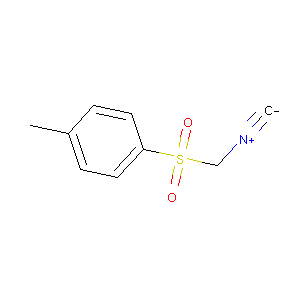

Cc1ccc(S(=O)(=O)CN=C=O)cc1


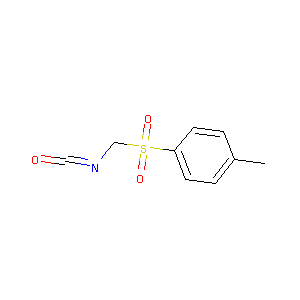

------new path------
CS(C)=O


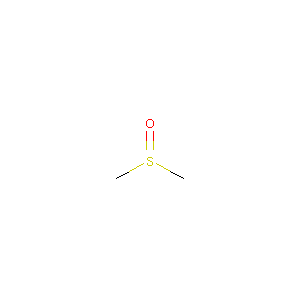

Cc1ccc(S(=O)(=O)CN=C=O)cc1


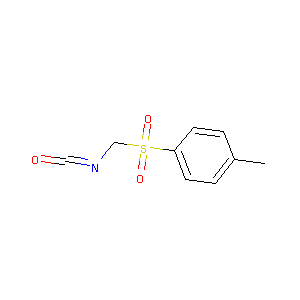

------new path------
O=S(=O)(c1ccc(cc1)C)C[N+]#[C-]


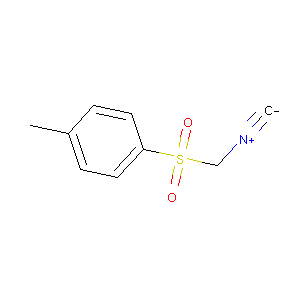

[C-]#[N+]C(C(=O)NCS(=O)(=O)c1ccc(C)cc1)S(=O)(=O)c1ccc(C)cc1


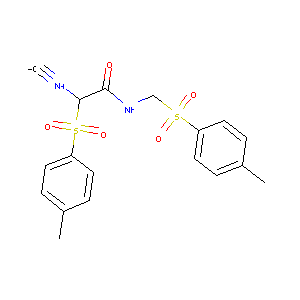

------new path------
Cc1ccc(S(=O)(=O)CN=C=O)cc1


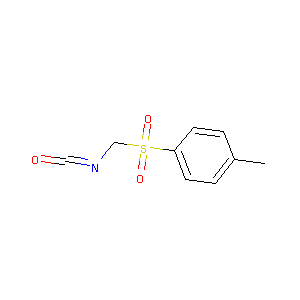

[C-]#[N+]C(C(=O)NCS(=O)(=O)c1ccc(C)cc1)S(=O)(=O)c1ccc(C)cc1


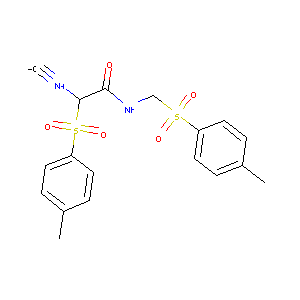

------new path------
[C-]#[N+]C(C(=O)NCS(=O)(=O)c1ccc(C)cc1)S(=O)(=O)c1ccc(C)cc1


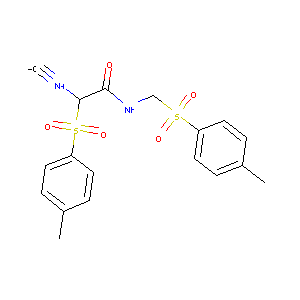

[C-]#[N+]CC(=O)NCS(=O)(=O)c1ccc(C)cc1


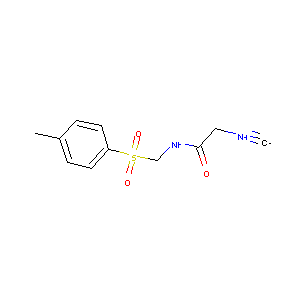

------new path------
[C-]#[N+]CC(=O)NCS(=O)(=O)c1ccc(C)cc1


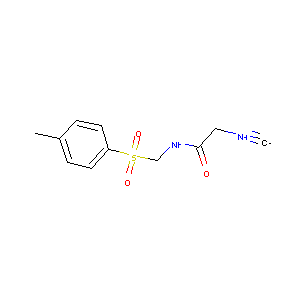

Cc1ccc(S(=O)(=O)CNC(=O)CN=C=O)cc1


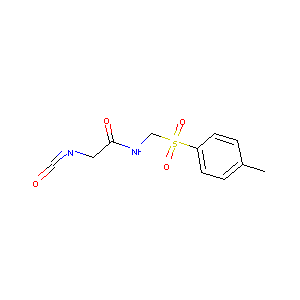

------new path------
CS(C)=O


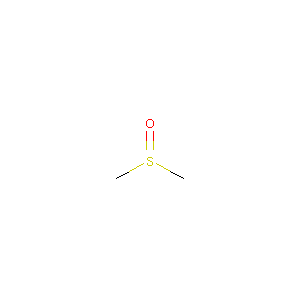

Cc1ccc(S(=O)(=O)CNC(=O)CN=C=O)cc1


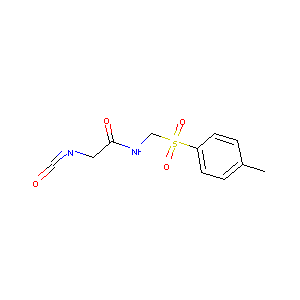

------new path------
Cc1ccc(S(=O)(=O)CNC(=O)CN=C=O)cc1


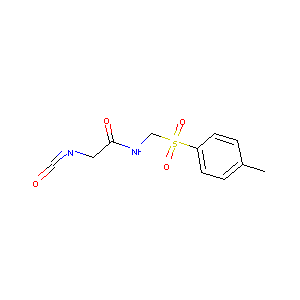

Cc1ccc(S(=O)(=O)CNC(=O)CN)cc1


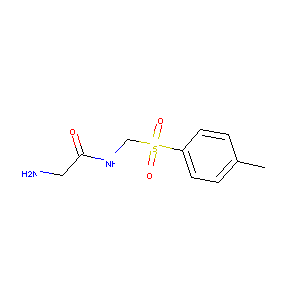

------new path------
O


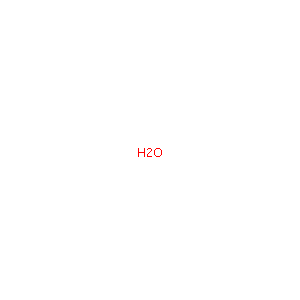

Cc1ccc(S(=O)(=O)CNC(=O)CN)cc1


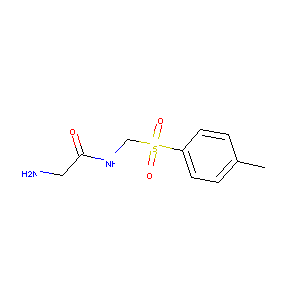

------new path------
Cc1ccc(S(=O)(=O)CNC(=O)CN)cc1


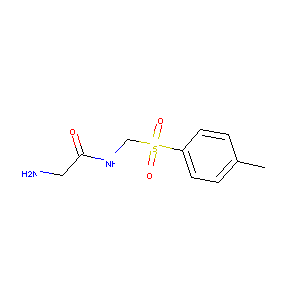

Cc1ccc(S(=O)(=O)CNC(=O)C=N)cc1


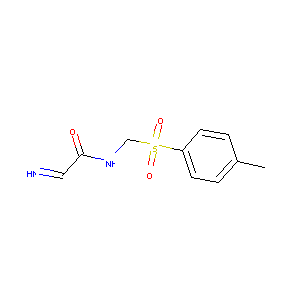

------new path------
Cc1ccc(S(=O)(=O)CNC(=O)C=N)cc1


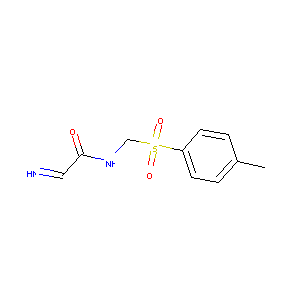

Cc1ccc(S(=O)(=O)CNC(=O)CNC(N)C(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1


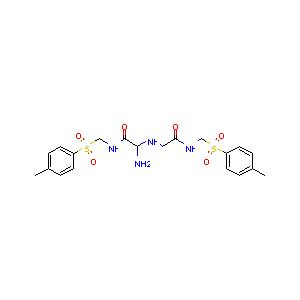

------new path------
Cc1ccc(S(=O)(=O)CNC(=O)CN)cc1


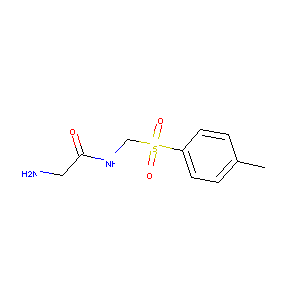

Cc1ccc(S(=O)(=O)CNC(=O)CNC(N)C(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1


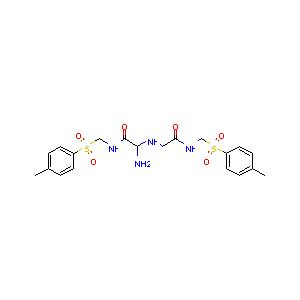

------new path------
Cc1ccc(S(=O)(=O)CNC(=O)CNC(N)C(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1


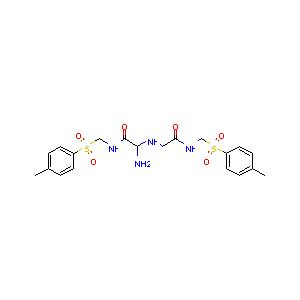

Cc1ccc(S(=O)(=O)CNC(=O)C=NCC(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1


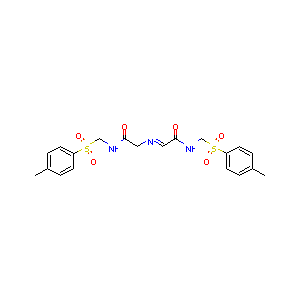

------new path------
Cc1ccc(S(=O)(=O)CNC(=O)C=NCC(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1


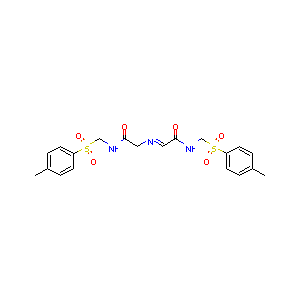

Cc1ccc(S(=O)(=O)CNC(=O)CNCC(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1


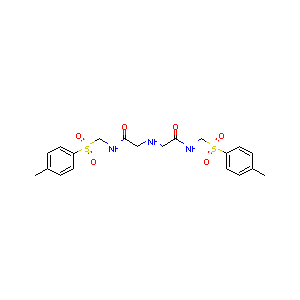

------new path------
Cc1ccc(S(=O)(=O)CNC(=O)CNCC(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1


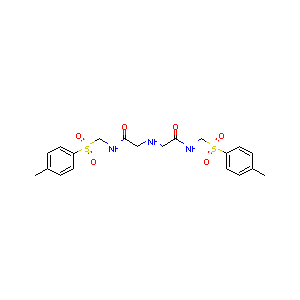

Cc1ccc(S(=O)(=O)CNC(=O)CN(CC(=O)NCS(=O)(=O)c2ccc(C)cc2)C(N)C(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1


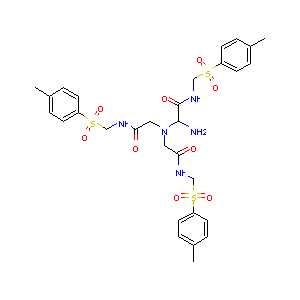

------new path------
Cc1ccc(S(=O)(=O)CNC(=O)C=N)cc1


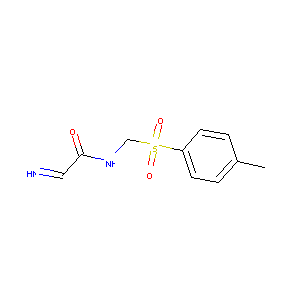

Cc1ccc(S(=O)(=O)CNC(=O)CN(CC(=O)NCS(=O)(=O)c2ccc(C)cc2)C(N)C(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1


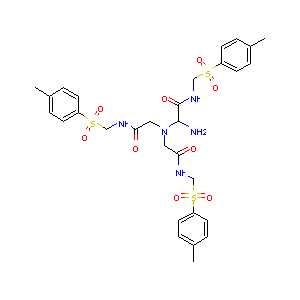

------new path------
Cc1ccc(S(=O)(=O)CNC(=O)CN(CC(=O)NCS(=O)(=O)c2ccc(C)cc2)C(N)C(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1


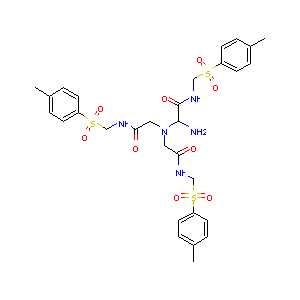

Cc1ccc(S(=O)(=O)CNC(=O)C=[N+](CC(=O)NCS(=O)(=O)c2ccc(C)cc2)CC(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1


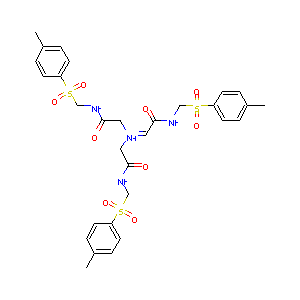

------new path------
Cc1ccc(S(=O)(=O)CNC(=O)C=[N+](CC(=O)NCS(=O)(=O)c2ccc(C)cc2)CC(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1


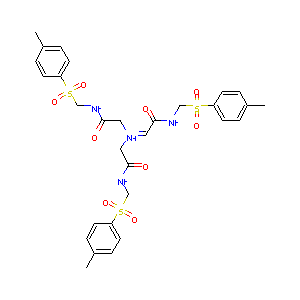

Cc1ccc(S(=O)(=O)CNC(=O)CN(CC(=O)NCS(=O)(=O)c2ccc(C)cc2)CC(=O)NCS(=O)(=O)c2ccc(C)cc2)cc1


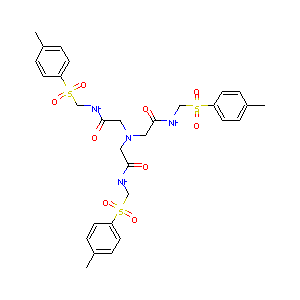

In [521]:
paths = trimer_path_edges
print(paths)
for path in paths:
    print('------new path------')
    for sml in path:
        if sml != None:
            print(sml)
            display(Draw.MolToImage(Chem.MolFromSmiles(sml)))

## tsne

In [232]:
def morgan_bits(smiles, radius, nbits):
    mol = Chem.MolFromSmiles(smiles)
    result = np.zeros(nbits)
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nbits)
    result[morgan_fp.GetOnBits()] = 1.0
    return result

#layout = nx.kamada_kawai_layout(forward_graph)

In [302]:
fingerprints = [morgan_bits(smiles, 3, 2048) for smiles in forward_graph]
node_smiles = [smiles for smiles in forward_graph]
fingerprint_matrix = np.concatenate([f[np.newaxis, :] for f in fingerprints], axis=0)

tsne = TSNE(n_components=1)

In [303]:
tsne.fit(fingerprint_matrix)

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
     method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
     n_components=1, n_iter=1000, n_iter_without_progress=300, n_jobs=None,
     perplexity=30.0, random_state=None, verbose=0)

In [304]:
tsne.embedding_.shape

(11596, 1)

## plotting graph

In [118]:
pruned_graph = prune_graph(forward_graph, [tosmic_smile], [trimer_smiles])

10000


In [256]:
def get_mol_in_gen(graph):

    mol_in_gen = [[] for i in range(18)]
    for x,y in dict(graph.nodes(data=True)).items():
        gen = y['generation']
        if gen<18:
            mol_in_gen[gen].append(x)
    return mol_in_gen

In [257]:
#manual scaling
def get_manual_coord(graph):
    mol_in_gen = get_mol_in_gen(graph)

    mols_coord = {}
    for gen,mol_gen in enumerate(mol_in_gen[1:14]):
        if len(mol_gen) <40:
            y_coords = np.arange(0,1,0.02)
            shift = y_coords[len(mol_gen)]/2
            y_coords = [i-shift for i in y_coords]
        elif len(mol_gen)<50:
            y_coords = [i-0.3 for i in np.arange(0,0.6,0.6/len(mol_gen))]
        elif len(mol_gen) < 300:
            y_coords = [i-0.55 for i in np.arange(0,1.1,1.1/len(mol_gen))]
        elif len(mol_gen) < 764:
            y_coords = [i-0.85 for i in np.arange(0,1.7,1.7/len(mol_gen))]
        else:
            y_coords = [i-1.3 for i in np.arange(0,2.6,2.6/len(mol_gen))]


        for i,mol in enumerate(mol_gen):
            mols_coord[mol] = [gen, y_coords[i]]
    return mols_coord

In [273]:
#auto scaling with number of molecules and random order
def get_auto_coord(graph):
    mol_in_gen = get_mol_in_gen(graph)

    mols_coord = {}
    for gen,mol_gen in enumerate(mol_in_gen[1:14]):

        y_coords = [i+1 for i in range(len(mol_gen))]
        #shift = len(mol_gen)/2
        #y_coords = [i-shift for i in y_coords]
        for i,mol in enumerate(mol_gen):
            mols_coord[mol] = [gen, y_coords[i]]
    return mols_coord

In [323]:
#tsne embedding
def get_tsne_coord(graph, tsne):
    mol_in_gen = [[] for i in range(18)]
    for (mol,data), y in zip(dict(graph.nodes(data=True)).items(), tsne.embedding_):
        gen = data['generation']
        if gen<18:
            mol_in_gen[gen].append([mol,y])

    mols_coord = {}
    for gen,mol_gen in enumerate(mol_in_gen[1:14]):

        for i,mol in enumerate(mol_gen):
            mols_coord[mol[0]] = [gen, mol[1][0]]
    return mols_coord


In [575]:
def get_auto_coord2(graph, trimer_graph, seed=0):
    def add_node(node, pool):
        coord = math.floor((len(pool) + 1)/2)
        pos = np.log10(coord+1)
#         pos = 250*coord / (250 + coord)
        pos *= (-1)**len(pool)
        pool.append(pos)
        return pos
    
    results = {gen: [] for gen in range(1,14)}
    mols = {}
    nodes = list(trimer_graph.nodes(data=True))
    random.seed(seed)
    random.shuffle(nodes)
    for node, data in nodes:
        gen = data["generation"]
        if gen > 13:
            continue
        pos = add_node(node, results[gen])
        mols[node] = (gen, pos)
    for node, data in graph.nodes(data=True):
        if node not in trimer_graph:
            gen = data["generation"]
            if gen > 13:
                continue
            pos = add_node(node, results[gen])
            mols[node] = (gen, pos)
    
    return mols

In [407]:
def get_auto_coord3(graph, trimer_graph):
    def add_node(node, pool):
        coord = math.floor((len(pool) + 1)/2)
        pos = 250*coord / (250 + coord)
        pos *= (-1)**len(pool)
        pool.append((pos, graph.in_degree())
        return pos
    
    results = {gen: [] for gen in range(1,14)}
    mols = {}
    for node, data in trimer_graph.nodes(data=True):
        gen = data["generation"]
        if gen > 13:
            continue
        pos = add_node(node, results[gen])
        mols[node] = (gen, pos)
    for node, data in graph.nodes(data=True):
        if node not in trimer_graph:
            gen = data["generation"]
            if gen > 13:
                continue
            pos = add_node(node, results[gen])
            mols[node] = (gen, pos)
    
    return mols

## Normal axis - TSNE - all molecules

In [ ]:
def plot_graph(graph, trimer_graph):
    f, a = plt.subplots(figsize=(25,17))
    mols_coord = get_tsne_coord(graph, tsne)
    print('coordinates done')
    graph_edges = list(set(graph.edges()))
    
    for i, (m1, m2) in enumerate(graph_edges):
        if i%1000 == 0:
            print(i)
        if m1 not in mols_coord or m2 not in mols_coord:
            continue
        mol1 = mols_coord[m1]
        mol2 = mols_coord[m2]
        if m1 in trimer_graph and m2 in trimer_graph:
            a.add_artist(Line2D([mol1[0], mol2[0]], [mol1[1], mol2[1]], c="blue", linewidth=0.1, zorder=1))
        else:
            a.add_artist(Line2D([mol1[0], mol2[0]], [mol1[1], mol2[1]], c="black", linewidth=0.05, zorder=1, alpha=0.2))

    all_coords = np.array([coords for mol, coords in mols_coord.items() if mol not in trimer_graph])
    trimer_coords = np.array([coords for mol, coords in mols_coord.items() if mol in trimer_graph])
    a.scatter(*all_coords.T, c="k", s=5, zorder=2)
    a.scatter(*trimer_coords.T, c="blue", s=10, zorder=2)

    for mol in trimer_flat_path:
        if mol != None:
            mol_coord=mols_coord[mol]
            a.scatter(mol_coord[0], mol_coord[1], c='r', s=10, zorder=3)
    for edge in trimer_path_edges:
        if None not in edge:
            mol1 = mols_coord[edge[0]]
            mol2 = mols_coord[edge[1]]
            a.plot([mol1[0], mol2[0]], [mol1[1], mol2[1]], c='red', linewidth=1.3, zorder=3)

    plt.xticks([])
    plt.yticks([])
    plt.savefig('chem_space_art.png', transparent=True, dpi=100)    

plot_graph(forward_graph, pruned_graph)

## Weird axis - starting from center - all molecules

In [439]:
great_good_red = sns.mpl_palette("Paired")[-1]

coordinates done
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000


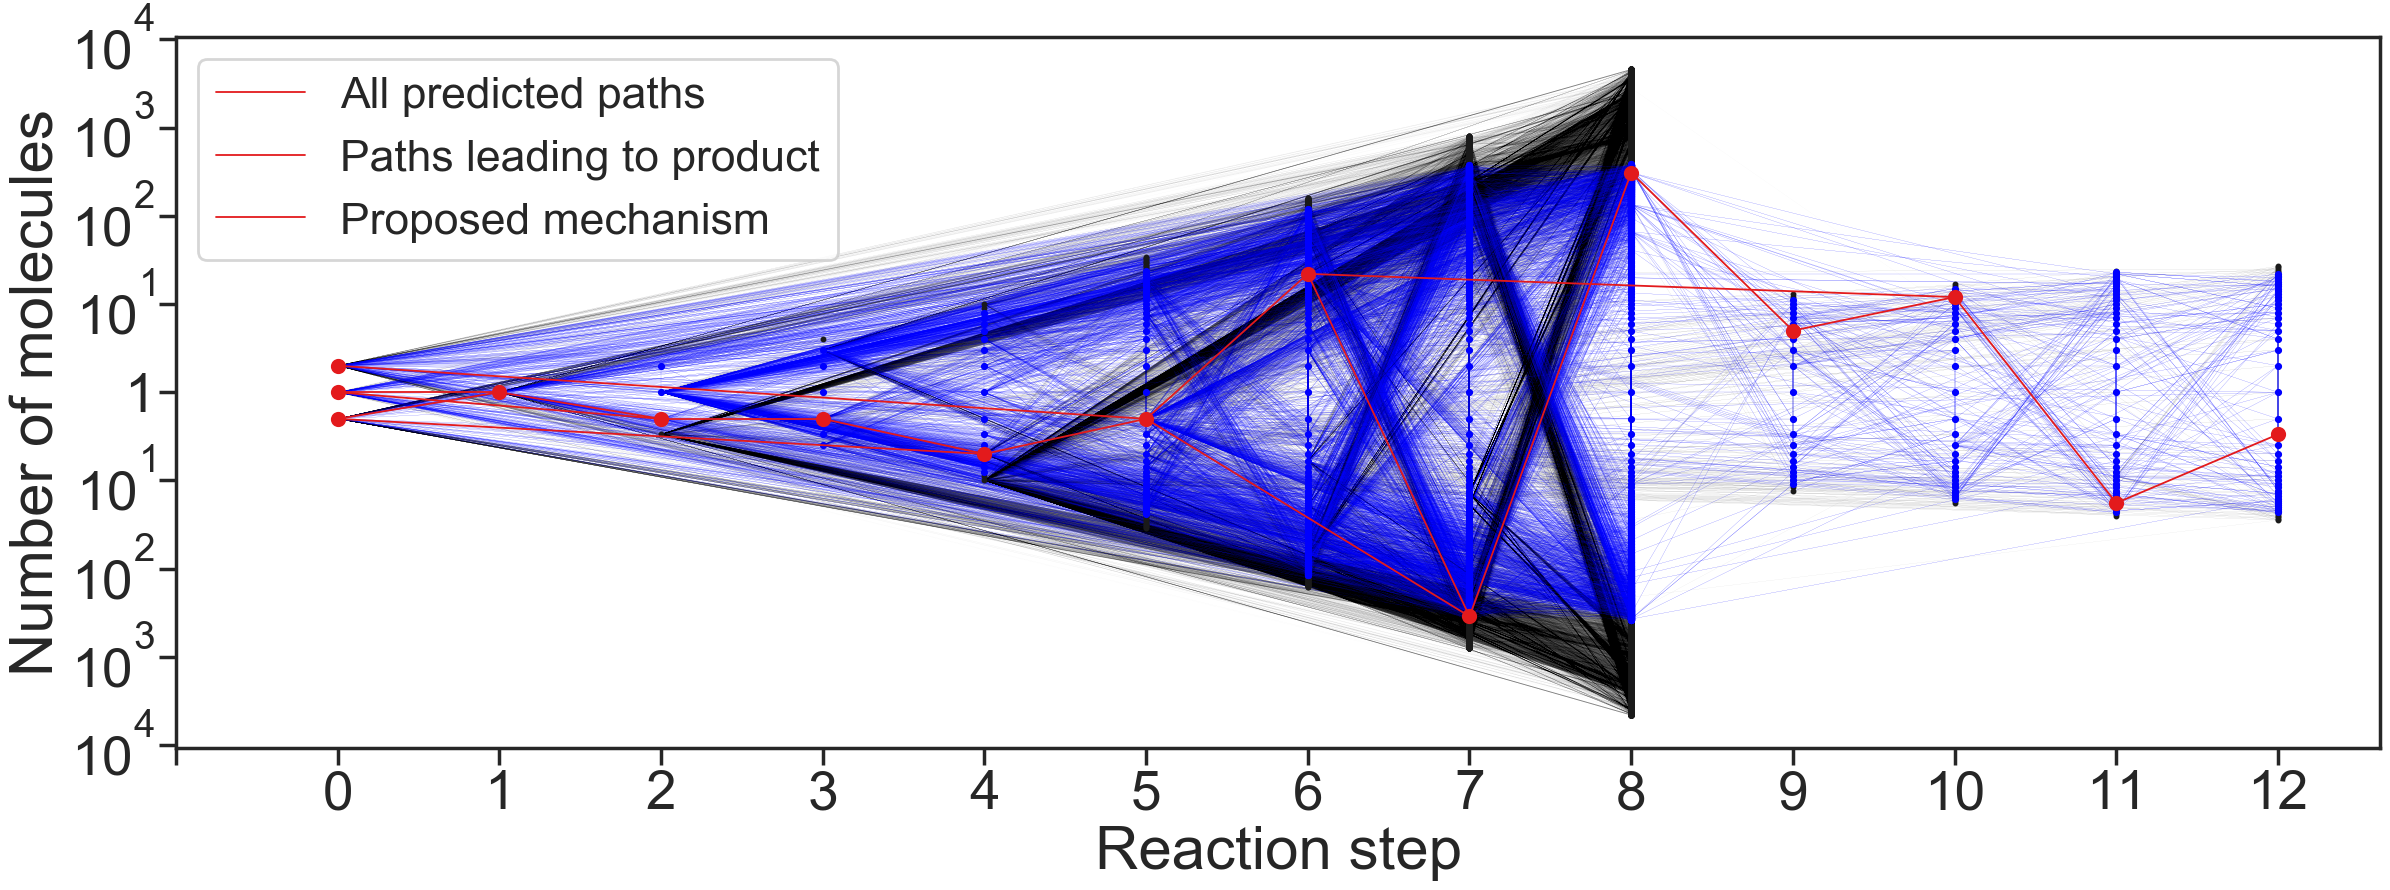

In [734]:
def plot_graph(graph, trimer_graph):
    f, a = plt.subplots(figsize=(25,10))
  
    
    mols_coord = get_auto_coord2(graph, trimer_graph, seed=24)
    print('coordinates done')
    graph_edges = list(set(graph.edges()))
    
    for i, (m1, m2) in enumerate(graph_edges):
        if i%1000 == 0:
            print(i)
        if m1 not in mols_coord or m2 not in mols_coord:
            continue
        mol1 = mols_coord[m1]
        mol2 = mols_coord[m2]
        if m1 in trimer_graph and m2 in trimer_graph:
            a.add_artist(Line2D([mol1[0], mol2[0]], [mol1[1], mol2[1]], c="blue", linewidth=0.1, zorder=1))
        else:
            alpha = 1 - max(abs(mol1[1]), abs(mol2[1])) / 3.9
            a.add_artist(Line2D([mol1[0], mol2[0]], [mol1[1], mol2[1]], c="black", linewidth=0.05, alpha=alpha, zorder=1))
    
    all_coords = np.array([coords for mol, coords in mols_coord.items() if mol not in trimer_graph])
    trimer_coords = np.array([coords for mol, coords in mols_coord.items() if mol in trimer_graph])
    a.scatter(*all_coords.T, c="k", s=5, zorder=2)
    a.scatter(*trimer_coords.T, c="blue", s=10, zorder=2)

    for mol in trimer_flat_path:
        if mol != None:
            mol_coord=mols_coord[mol]
            a.scatter(mol_coord[0], mol_coord[1], c=great_good_red, s=80, zorder=3)
    for edge in trimer_path_edges:
        if None not in edge:
            mol1 = mols_coord[edge[0]]
            mol2 = mols_coord[edge[1]]
            a.plot([mol1[0], mol2[0]], [mol1[1], mol2[1]], c=great_good_red, linewidth=1.3, zorder=3)
    
    a.set_yticks(np.arange(-4, 5))
    a.set_xticks(np.arange(0, 14))
    
    ticks = {exponent: f"$10^{abs(exponent)}$" for exponent in a.get_yticks()}
    ticks[0] = 1
    a.set_yticklabels([ticks[exponent] for exponent in a.get_yticks()])
    a.set_xticklabels([int(tick-1) if tick > 0 else "" for tick in a.get_xticks()])
    
    
    a.set_ylabel("Number of molecules")
    a.set_xlabel("Reaction step")
    a.legend(["All predicted paths", "Paths leading to product", "Proposed mechanism"], loc="upper left", fontsize=32)
    
    
    return f


f = plot_graph(forward_graph, pruned_graph)

In [735]:
f.savefig("chemical_space_full_log.png", transparent=True, bbox_inches="tight", pad_inches=0.1, dpi=300)

In [922]:
def remove_background(img):
    img = img.convert("RGBA")
    datas = img.getdata()

    newData = []
    for item in datas:
        if item[0] == 255 and item[1] == 255 and item[2] == 255:
            newData.append((255, 255, 255, 0))
        else:
            if item[0] > 150:
                newData.append((0, 0, 0, 255))
            else:
                newData.append(item)
    img.putdata(newData)
    return img

In [115]:
G = nx.DiGraph()

# labels = dict()

# graph showing formation of `node` from its predecessors
def build_pred_graph(graph, node):
    nodes_to_visit = list(graph.predecessors(node))
    while True:
#         G.add_node(node, image= remove_background(Draw.MolToImage(Chem.MolFromSmiles(node))), size=0.5)
        if not nodes_to_visit:
            break
        for n in graph.predecessors(node):
#             G.add_node(n, image=remove_background(Draw.MolToImage(Chem.MolFromSmiles(n))),size=0.5)
            rxn = graph.get_edge_data(n,node)[0]['rxn']
#             labels[(n,node)]=rxn
            G.add_edge(n, node, rxn=rxn)
        node = nodes_to_visit.pop()
        nodes_to_visit.extend(n for n in graph.predecessors(node) if n not in nodes_to_visit and n not in G)
            
# for r in reagents:
#     build_pred_graph(graph, r)
# trimer_smiles in cs_rev.reactivity_graph
# build_pred_graph(cs_rev.reactivity_graph, trimer_smiles)

False

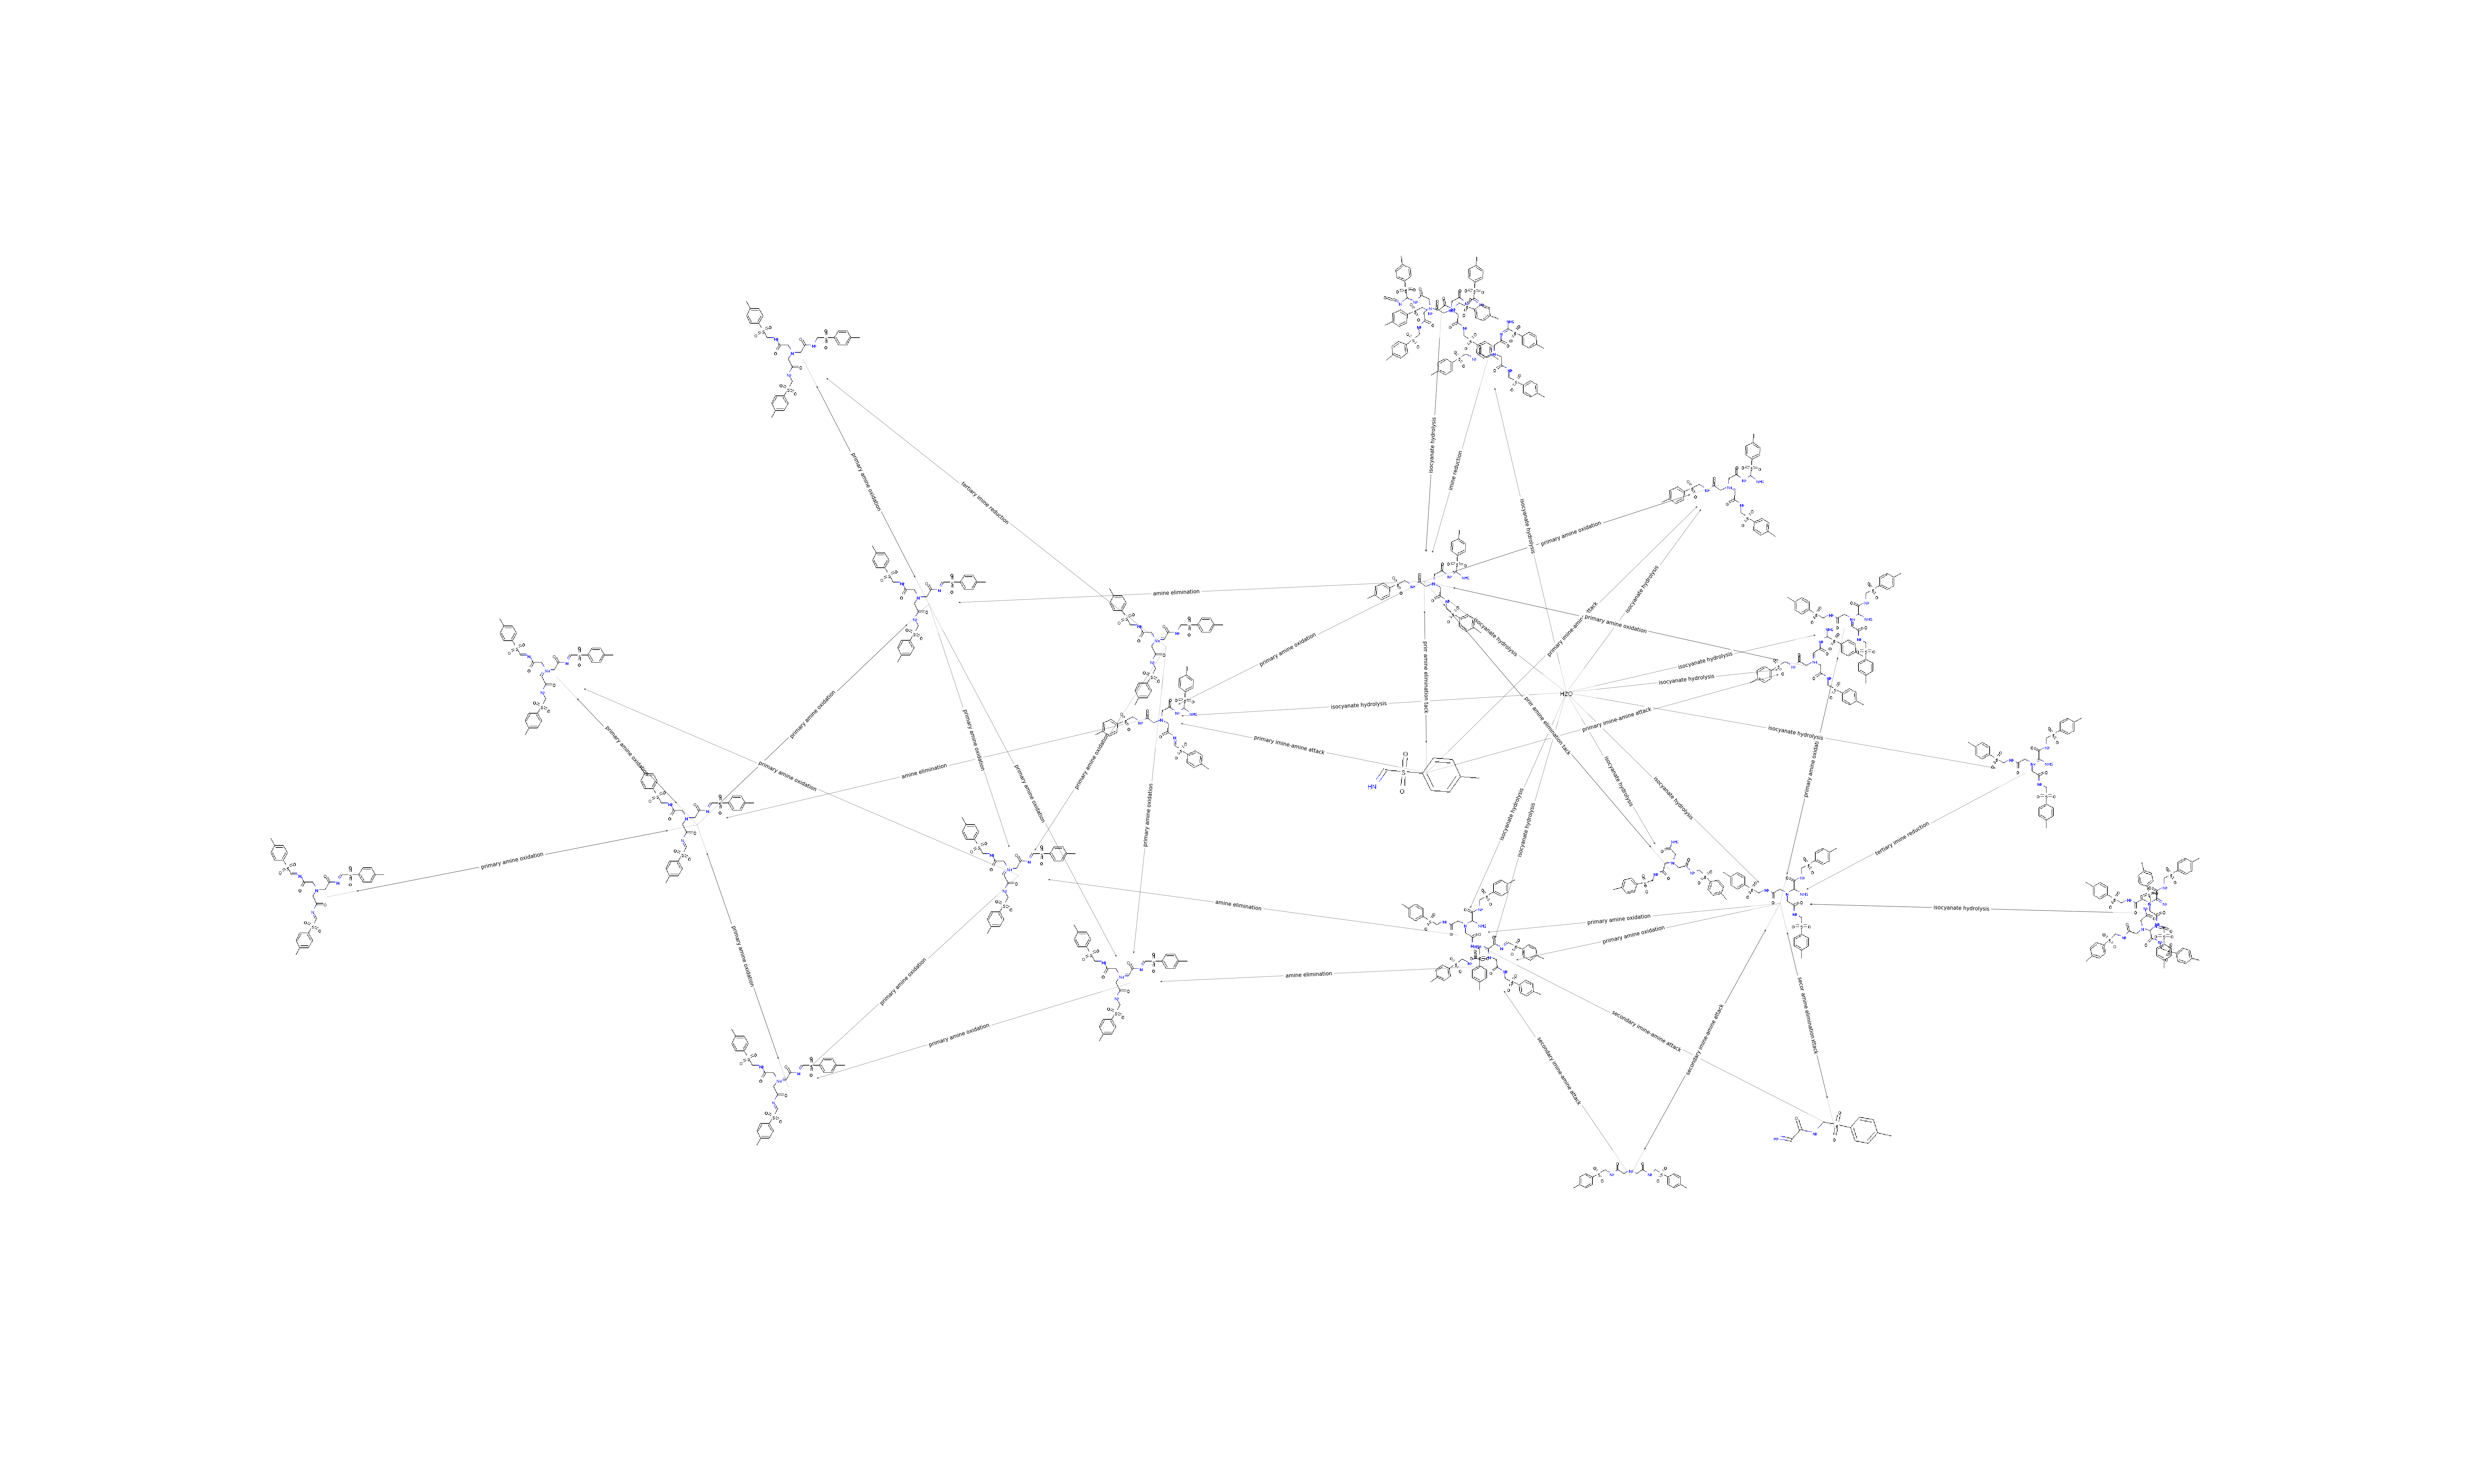

In [924]:
pos = nx.kamada_kawai_layout(G)
nx.draw(G,pos, node_size=30000,arrows=True, alpha=0.5, node_color='w')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,font_size=15)

ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches(100, 60)
label_pos = 0.5 # middle of edge, halfway between nodes
trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform
imsize = 0.10 # this is the image size
rxnsize = 0.1
for n in G.nodes():
    (x,y) = pos[n]
    xx,yy = trans((x,y)) # figure coordinates
    xa,ya = trans2((xx,yy)) # axes coordinates
    a = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
    a.imshow(G.nodes[n]['image'])
    a.set_aspect('equal')
    a.axis('off')
#plt.savefig('trimer_graph.svg')
plt.savefig('trimer_graph2.png')

plt.show()

In [232]:
import pickle

In [233]:
with open("graph_limited_forward.pickle", "wb") as f:
    pickle.dump(cs, f)